<a href="https://colab.research.google.com/github/JeremyAlain/Advanced-Quick-Summary-on-Deep-Learning-by-Goodfellow-Bengio-and-Courville/blob/master/plots/Learning_from_NL_Feedback_Workshop_Results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import sem
import numpy as np
import seaborn as sns
import re
from typing import List
from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path
fig_output_path = Path("/content/drive/MyDrive/learning_from_natural_langauge_feedback/workshop_results/figures/")

import matplotlib
params = {'axes.labelsize': 18, 'axes.titlesize':20, 'legend.fontsize': 20, 'xtick.labelsize': 28, 'ytick.labelsize': 40}
matplotlib.rcParams.update(params)

Mounted at /content/drive


# Targeted Feedback Experiments

**Description**

We sample an offensive sentence with $o=\{1,10\}$ offensive words in it, plus the sentence-part "you are a nice person". The offensive words are sampled from a list with 27 offensive words in them. For each case of a specific number of bad words, e.g. $o=3$, we sample $k=50$ offensive sentences.
Example: 
* You are such an asshole, and a dick, and an idiot, and a nice person 
* You are such a dick, and a shit, and a nice person, and a fucker 
* .....

For all $o=\{1,10\}$ and $k$ sentences we do $m=3$ experiments where we remove $f=\{1,3\}$ forbidden words from the offensive sentences (note $m=|f|$). 

In [ ]:
model_names = ["davinci","text-davinci-001", "curie","text-curie-001","babbage",  "text-babbage-001", "ada",  "text-ada-001",  ]
model_names_for_plotting = {"ada": "GPT-3\n350M", 
                            "babbage": "GPT-3\n1.3B", 
                           "curie": "GPT-3\n6.7B", 
                           "davinci": "GPT-3\n175B", 
                           "text-ada-001": "GPT-3\n350M\nInstruct", 
                            "text-babbage-001": "GPT-3\n1.3B\nInstruct",
                            "text-curie-001": "GPT-3\n6.7B\nInstruct",
                            "text-davinci-001": "GPT-3\n175B\nInstruct"
                           }
model_names_to_sizes = {"ada": 350e6, 
                        "babbage": 1.3e9, 
                        "curie": 6.7e9, 
                        "davinci": 175e9, 
                        "text-ada-001": 350e6, 
                        "text-babbage-001": 1.3e9,
                        "text-curie-001": 6.7e9,
                        "text-davinci-001": 175e9
                        }
drive_path = "/content/drive/MyDrive/learning_from_natural_langauge_feedback/workshop_results/targeted_word_removal"

def plot_targeted_feedback_results_old(model_names: List[str], max_number_of_offensive_words: int, max_number_of_forbidden_words: int, number_of_samples: int, metric="string_matching") -> None: 
  #colors = plt.cm.viridis(np.linspace(0,1,len(model_names)))
  colors = sns.color_palette("tab10", n_colors=len(model_names))

  for number_of_forbidden_words in range(1, max_number_of_forbidden_words+1):
    plot_x_axis_range = np.arange(number_of_forbidden_words, max_number_of_offensive_words+1)
    fig, ax = plt.subplots()
    for i, model_name in enumerate(model_names): 
      result_dataframe = pd.read_json("{}/{}_offensive_sentences_dataset_with_results.json".format(drive_path, model_name))
      model_mean_across_number_of_offensive_words = []
      model_standard_error_across_number_of_offensive_words = []

      assert result_dataframe.shape[0] == number_of_samples
      for number_of_offensive_words in range(1, max_number_of_offensive_words+1): 
        if number_of_forbidden_words > number_of_offensive_words: 
          continue
        model_results_for_specific_number_of_offensive_words = []
        for sample_id in range(number_of_samples): 
          prediction = result_dataframe.iloc[sample_id]["{}_offensive_words_{}_forbidden_words_completion".format(number_of_offensive_words, number_of_forbidden_words)]
          target_sentence = result_dataframe.iloc[sample_id]["{}_offensive_words_{}_forbidden_words_target_sentence".format(number_of_offensive_words, number_of_forbidden_words)]
          target_sentence = target_sentence.split("You are")[1]

          if metric == "string_matching": 
            sample_accuracy = int(target_sentence==prediction)
          elif metric == "all_forbidden_words_gone": 
            forbidden_words = result_dataframe.iloc[sample_id]["{}_offensive_words_{}_forbidden_words_list".format(number_of_offensive_words, number_of_forbidden_words)]
            
            sample_accuracy = 1
            for forbidden_word in forbidden_words: 
              if re.search(r'\b' + forbidden_word + r'\b', prediction) is not None:
                sample_accuracy = 0
                break 
          else: 
            raise NotImplementedError()
          model_results_for_specific_number_of_offensive_words.append(sample_accuracy)
        
        model_mean_across_number_of_offensive_words.append(np.mean(model_results_for_specific_number_of_offensive_words))
        model_standard_error_across_number_of_offensive_words.append(sem(model_results_for_specific_number_of_offensive_words))

      assert len(model_mean_across_number_of_offensive_words) == len(model_standard_error_across_number_of_offensive_words) == max_number_of_offensive_words - number_of_forbidden_words +1

      model_mean_across_number_of_offensive_words = np.array(model_mean_across_number_of_offensive_words)
      model_standard_error_across_number_of_offensive_words = np.array(model_standard_error_across_number_of_offensive_words)
      if "text" in model_name: 
        ax.plot(plot_x_axis_range, model_mean_across_number_of_offensive_words, "--", color=colors[i], label=model_names_for_plotting[model_name])
      else:
        ax.plot(plot_x_axis_range, model_mean_across_number_of_offensive_words, color=colors[i], label=model_names_for_plotting[model_name])
      ax.fill_between(plot_x_axis_range, 
                      model_mean_across_number_of_offensive_words-model_standard_error_across_number_of_offensive_words, 
                      model_mean_across_number_of_offensive_words+model_standard_error_across_number_of_offensive_words,
                      color=colors[i], 
                      alpha=0.2)
    plt.ylabel("Accuracy")
    plt.xlabel("Number of offensive words")
    plt.xticks(np.arange(number_of_forbidden_words, 11))
    if number_of_forbidden_words > 1:
      plt.title("{} Forbidden words".format(number_of_forbidden_words))
    else: 
      plt.title("{} Forbidden word".format(number_of_forbidden_words))
      plt.legend(loc='upper center', bbox_to_anchor=(1.2, 0.8))

  plt.show()


## Exact Sting Matching - Results
Accuracy is 1 if the prediction exactly matches the target sentence. 


**Example: Accuracy = 1**

*   Original Sentence: You are such a dich, and a nice person, and an asshole.
*   Forbidden Word: Asshole
*   Completion: You are such a dick, and a nice person. 
*   Target: You are such a dichk, and a nice person

**Example: Accuracy = 0**

*   Original Sentence: You are such a dich, and a nice person, and an asshole.
*   Forbidden Word: Asshole
*   Completion: You are such a nice person. 
*   Target: You are such a dick, and a nice person

In [ ]:
def plot_targeted_feedback_results(model_names: List[str], max_number_of_offensive_words: int, max_number_of_forbidden_words: int, number_of_samples: int, metric="string_matching") -> None: 
  colors = ["#ce776b", "#f3c07d", "#96c79d"]
  x_axis_range = np.arange(len(model_names))
  width = 0.25
  fig, ax = plt.subplots()

  for number_of_forbidden_words in range(1, max_number_of_forbidden_words+1): 
    all_model_mean_results_for_number_of_forbidden_words = []
    all_model_standard_error_results_for_number_of_forbidden_words = []

    for i, model_name in enumerate(model_names): 
      result_dataframe = pd.read_json("{}/{}_offensive_sentences_dataset_with_results.json".format(drive_path, model_name))

      model_results_for_number_of_forbidden_words = []
      assert result_dataframe.shape[0] == number_of_samples
      for number_of_offensive_words in range(1, max_number_of_offensive_words+1): 
        if number_of_forbidden_words > number_of_offensive_words: 
          continue
        for sample_id in range(number_of_samples): 
          prediction = result_dataframe.iloc[sample_id]["{}_offensive_words_{}_forbidden_words_completion".format(number_of_offensive_words, number_of_forbidden_words)]
          target_sentence = result_dataframe.iloc[sample_id]["{}_offensive_words_{}_forbidden_words_target_sentence".format(number_of_offensive_words, number_of_forbidden_words)]
          target_sentence = target_sentence.split("You are")[1]

          if metric == "string_matching": 
            sample_accuracy = int(target_sentence==prediction)
          else: 
            raise NotImplementedError()
          model_results_for_number_of_forbidden_words.append(sample_accuracy)
      all_model_mean_results_for_number_of_forbidden_words.append(np.mean(model_results_for_number_of_forbidden_words))
      all_model_standard_error_results_for_number_of_forbidden_words.append(sem(model_results_for_number_of_forbidden_words))
      
    assert len(x_axis_range) == len(model_names)
    if number_of_forbidden_words == 1: 
      ax.bar(x_axis_range - width, all_model_mean_results_for_number_of_forbidden_words, width, yerr=all_model_standard_error_results_for_number_of_forbidden_words , label="{} Forbidden Words".format(number_of_forbidden_words), color=colors[number_of_forbidden_words-1])
    elif number_of_forbidden_words == 2: 
      ax.bar(x_axis_range, all_model_mean_results_for_number_of_forbidden_words,width,yerr=all_model_standard_error_results_for_number_of_forbidden_words, label="{} Forbidden Words".format(number_of_forbidden_words),  color=colors[number_of_forbidden_words-1])
    elif number_of_forbidden_words == 3: 
      ax.bar(x_axis_range + width, all_model_mean_results_for_number_of_forbidden_words,width, yerr=all_model_standard_error_results_for_number_of_forbidden_words, label="{} Forbidden Words".format(number_of_forbidden_words), color=colors[number_of_forbidden_words-1])
    else:
      raise NotImplementedError()

    plt.ylabel("String Accuracy (%)")
    plt.legend()
    plt.xticks(x_axis_range, [model_names_for_plotting[model_name] for model_name in model_names], rotation=0)
    plt.savefig(fig_output_path / "targeted_feedback_results.pdf", bbox_inches='tight')

def plot_targeted_feedback_results(model_names: List[str], max_number_of_offensive_words: int, max_number_of_forbidden_words: int, number_of_samples: int, metric="string_matching") -> None: 
  colors = ["#ce776b", "#f3c07d", "#96c79d"]
  x_axis_range = np.array([model_names_to_sizes[model_name] for model_name in model_names if model_name.startswith('text')])
  fig, ax = plt.subplots()

  all_model_results = [] # List [[name, mean, sem], [name, mean, sem], ...]
  for i, model_name in enumerate(model_names): 
    result_dataframe = pd.read_json("{}/{}_offensive_sentences_dataset_with_results.json".format(drive_path, model_name))

    model_results_for_number_of_forbidden_words = []
    for number_of_forbidden_words in range(1, max_number_of_forbidden_words+1): 
      assert result_dataframe.shape[0] == number_of_samples
      for number_of_offensive_words in range(1, max_number_of_offensive_words+1): 
        if number_of_forbidden_words > number_of_offensive_words: 
          continue
        for sample_id in range(number_of_samples): 
          prediction = result_dataframe.iloc[sample_id]["{}_offensive_words_{}_forbidden_words_completion".format(number_of_offensive_words, number_of_forbidden_words)]
          target_sentence = result_dataframe.iloc[sample_id]["{}_offensive_words_{}_forbidden_words_target_sentence".format(number_of_offensive_words, number_of_forbidden_words)]
          target_sentence = target_sentence.split("You are")[1]

          if metric == "string_matching": 
            sample_accuracy = int(target_sentence==prediction)
          else: 
            NotImplementedError()
          model_results_for_number_of_forbidden_words.append(sample_accuracy)
    all_model_results.append([
        model_name,
        np.mean(model_results_for_number_of_forbidden_words) * 100,
        sem(model_results_for_number_of_forbidden_words) * 100,
    ])
    
  assert len(all_model_results) == len(model_names), len(all_model_results)
  # ax.bar(x_axis_range, all_model_mean_results, width, yerr=all_model_standard_error_results)
  print(model_names)

  # Plot GPT-3
  gpt3_means = [mean for name, mean, sem in all_model_results if not name.startswith('text')]
  gpt3_errs = [sem for name, mean, sem in all_model_results if not name.startswith('text')]
  print("gpt3_means", gpt3_means)
  print("gpt3_errs", gpt3_errs)
  gpt3_means = np.array(gpt3_means)
  gpt3_errs = np.array(gpt3_errs)
  #ax.errorbar(x_axis_range, gpt3_means, yerr=gpt3_errs, label='GPT-3')
  plt.plot(x_axis_range, gpt3_means, marker="o", label='GPT-3', color=colors[0])
  ax.fill_between(x_axis_range, 
                    gpt3_means-gpt3_errs, 
                    gpt3_means+gpt3_errs,
                    color=colors[0], 
                    alpha=0.2)
  # Plot GPT-3-Instruct
  gpt3_inst_means = [mean for name, mean, sem in all_model_results if name.startswith('text')]
  gpt3_inst_errs = [sem for name, mean, sem in all_model_results if name.startswith('text')]
  print("gpt3_inst_means", gpt3_inst_means)
  print("gpt3_inst_errs", gpt3_inst_errs)
  gpt3_inst_means = np.array(gpt3_inst_means)
  gpt3_inst_errs = np.array(gpt3_inst_errs)
  #ax.errorbar(x_axis_range, gpt3_inst_means, yerr=gpt3_inst_errs, label='GPT-3 Instruct')
  plt.plot(x_axis_range, gpt3_inst_means,  colors[1], marker="o",label='InstructGPT')
  ax.fill_between(x_axis_range, 
                    gpt3_inst_means-gpt3_inst_errs, 
                    gpt3_inst_means+gpt3_inst_errs,
                    color=colors[1], 
                    alpha=0.2)
  # Annotate model sizes
  gpt3_names = [model_names_for_plotting[name].split()[1] for name in model_names if not name.startswith('text')]
  for x, y, name in zip(x_axis_range, gpt3_means, gpt3_names):
    if name == '350M':
      ax.annotate(name, (x, y + 3), ha='left')
    elif name == '175B':
      ax.annotate(name, (x, y + 4), ha='right')
    else:
      ax.annotate(name, (x, y + 4), ha='center')

  ax.set_xscale('log')
  ax.set_xlim(350e6, 175e9)
  ax.set_ylim(0, 47)
  # ax.invert_xaxis()
  plt.xlabel("# of parameters")
  plt.ylabel("Accuracy (%)")
  plt.legend()
  plt.savefig(fig_output_path / "targeted_feedback_results.pdf", bbox_inches='tight')
  

['davinci', 'text-davinci-001', 'curie', 'text-curie-001', 'babbage', 'text-babbage-001', 'ada', 'text-ada-001']
gpt3_means [38.51851851851852, 8.74074074074074, 1.1111111111111112, 0.962962962962963]
gpt3_errs [1.3249545310156892, 0.7689650729729905, 0.2853951043929671, 0.26588732603673787]
gpt3_inst_means [35.629629629629626, 5.407407407407407, 2.5185185185185186, 1.5555555555555556]
gpt3_inst_errs [1.3038951895175976, 0.615768027591235, 0.426606688136781, 0.3369243463651187]


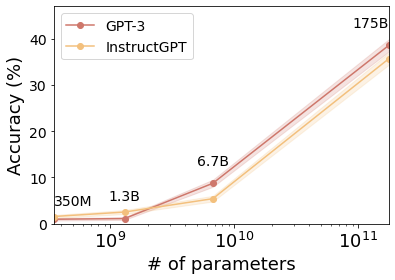

In [ ]:
params = {'font.size': 14, 'axes.labelsize': 18, 'legend.fontsize': 14, 'xtick.labelsize': 18, 'ytick.labelsize': 14}
matplotlib.rcParams.update(params)
plot_targeted_feedback_results(model_names, max_number_of_offensive_words=10, max_number_of_forbidden_words=3, number_of_samples=50, metric="string_matching")

## All forbidden words gone - Results
Accuracy is 1 if all the forbidden words are gone from the completion. This metric is agnostic to other changes to the sentence.


**Example: Accuracy = 1**
*   Original Sentence: You are such a dick, and a nice person, and an asshole.
*   Forbidden Word: Asshole
*   Completion: You are such a nice person. 

**Example: Accuracy = 0**
*   Original Sentence: You are such a dick, and a nice person, and an asshole.
*   Forbidden Word: Asshole
*   Completion: You are a nice person, and an asshole.


**!! Attention!!!**
I plotted this metric merely as additional Information. I would completely ignore this metric however, since it is not well aligned with intution. We can see for example that when we remove 3 forbidden words, Curie-instruct is better than davinci, which is weird. However when looking at some of the "correct" completions, many of those are just sentences such as "You are such a nice person", or "You are such a person, and a nice person". This happens for all types of models. The metric will those cases as the forbidden word is gone. However since those generations are very noisy, we are essenitally measuring a signal from noise. Especially if we start removing more words the outputs become worse and worse. This is my current understanding for why this looks weird. I am not 100% sure though if this is the reason.

In [ ]:
#plot_targeted_feedback_results_old(model_names, max_number_of_offensive_words=10,max_number_of_forbidden_words=3,number_of_samples=50, metric="all_forbidden_words_gone")

# Human Comparison Experiments
---



In [ ]:
results_file = "/content/drive/MyDrive/learning_from_natural_langauge_feedback/workshop_results/comparison/human_eval_comparison_summaries_with_aggregated_results.csv"
methods = ["original_summary_comparison_rank", "feedback_refinements_reranking_comparison_rank", "feedback_refinements_random_comparison_rank",
           "general_refinements_random_comparison_rank", 
           "human_reference_summaries_comparison_rank"]
methods_without_original  = ["feedback_refinements_reranking_comparison_rank", "feedback_refinements_random_comparison_rank",
           "general_refinements_random_comparison_rank", 
           "human_reference_summaries_comparison_rank"]

method_names_for_plotting = {"original_summary_comparison_rank": "Initial Summaries", 
                             "feedback_refinements_reranking_comparison_rank": "Refine w/ Feedback + Best of N", 
                             "feedback_refinements_random_comparison_rank": "Refine w/ Feedback", 
                             "general_refinements_random_comparison_rank": "Refine w/o Feedback", 
                             "human_reference_summaries_comparison_rank": "Human Summaries"
                             }
evaluators = ["Jun", "Angie"]

## Average Ranking

In [ ]:
def calcualte_average_ranking_per_summary(results_file: str, methods: List[str], evaluators: List[str]): 
  result_dataframe = pd.read_csv(results_file)
  mean_rank_per_method = {}
  standard_error_of_rank_per_method = {}
  for method in methods: 
    results = []
    for evaluator in evaluators: 
      results += result_dataframe[method + "_{}".format(evaluator)].to_list()
    results = np.array(results)
    mean_rank_per_method[method] = np.mean(results)
    standard_error_of_rank_per_method[method] = sem(results)

  for method in methods: 
    print("Average Ranking:")
    print("{}: {} +/- {}".format(method_names_for_plotting[method],mean_rank_per_method[method], standard_error_of_rank_per_method[method]))

In [ ]:
calcualte_average_ranking_per_summary(results_file, methods, evaluators)

Average Ranking:
Initial Summaries: 3.385 +/- 0.08392910983316178
Average Ranking:
Refine w/ Feedback + Best of N: 2.5425 +/- 0.0977624993614987
Average Ranking:
Refine w/ Feedback: 2.8675 +/- 0.08148106880045401
Average Ranking:
Refine w/o Feedback: 3.35 +/- 0.08395081115431427
Average Ranking:
Human Summaries: 2.86 +/- 0.11621977101973398


## Win Rate

In [ ]:
def add_linebreaks(text, max_line=12):
  words = text.split()
  new_text = ""
  current_line_len = 0
  for word in words:
    word = " " + word
    if current_line_len + len(word) > max_line:
      new_text += '\n' + word
      current_line_len = len(word)
    else:
      new_text += word
      current_line_len += len(word)
  return new_text

def plot_win_rate_against_original_summary(results_file: str, methods: List[str], evaluators: List[str], metric: str="win_rate_with_tie_scoring"): 
  #colors = ["#8ecbd7", "#abd4ff", "#96c79d", "#f3c07d", "#ce776b"]
  colors = ["#ce776b", "#f3c07d", "#96c79d", "#abd4ff"]
  result_dataframe = pd.read_csv(results_file)
  number_of_samples = result_dataframe.shape[0]

  win_rate_per_method = {}
  standard_error_of_win_rate_per_method = {}
  for method in methods:
    original_summaries_over_evaluators = []
    method_results_over_evaluators = []
    for evaluator in evaluators:
      original_summaries_over_evaluators += result_dataframe["original_summary_comparison_rank_{}".format(evaluator)].to_list()
      method_results_over_evaluators += result_dataframe[method + "_{}".format(evaluator)].to_list()
    
    assert len(original_summaries_over_evaluators) == len(method_results_over_evaluators) == number_of_samples*len(evaluators)
    original_summaries_over_evaluators = np.array(original_summaries_over_evaluators)
    method_results_over_evaluators = np.array(method_results_over_evaluators)
    

    if metric == "win_rate_with_tie_scoring": 
      wins = method_results_over_evaluators < original_summaries_over_evaluators
      ties =  method_results_over_evaluators == original_summaries_over_evaluators
      assert len(wins) == len(ties)

      current_method_performance = wins + 0.5*ties
    else: 
      raise NotImplementedError()    
    win_rate_per_method[method] = np.mean(current_method_performance)
    standard_error_of_win_rate_per_method[method] = sem(current_method_performance)
  
  method_titles = [add_linebreaks(method_names_for_plotting[method]) for method in methods]
  win_rates = [win_rate_per_method[method] * 100 for method in methods]
  standard_errors = [standard_error_of_win_rate_per_method[method] * 100 for method in methods]
  print(win_rate_per_method)
  print(standard_error_of_win_rate_per_method)
  print("Methods", method_titles)
  print("Win rates:", win_rates)
  print("Standard error",standard_errors )
  x_axis = range(len(methods))
  fig, ax = plt.subplots()
  ax.bar(x_axis, win_rates, yerr=standard_errors, color=colors)
  ax.axhline(y=50, color='black', linestyle='--')
  ax.text(2.1, 45, "Initial Summaries")
  plt.ylabel("Win Rate vs. \n Initial Summaries (%)")
  # plt.title("Win rate vs. Initial Summary")
  plt.xticks(x_axis, method_titles, rotation=0)
  plt.savefig(fig_output_path / f"win_rate_vs_original_summary_{metric}.pdf", bbox_inches='tight')
  plt.show()

In [ ]:
params = {'font.size': 12, 'axes.labelsize': 14, 'legend.fontsize': 20, 'xtick.labelsize': 12, 'ytick.labelsize': 14}
matplotlib.rcParams.update(params)
#plot_win_rate_against_original_summary(results_file, methods_without_original, evaluators, metric="win_rate")

{'feedback_refinements_reranking_comparison_rank': 0.67, 'feedback_refinements_random_comparison_rank': 0.605, 'general_refinements_random_comparison_rank': 0.5025, 'human_reference_summaries_comparison_rank': 0.6075}
{'feedback_refinements_reranking_comparison_rank': 0.03119077302036678, 'feedback_refinements_random_comparison_rank': 0.030198256131221127, 'general_refinements_random_comparison_rank': 0.02616566375613267, 'human_reference_summaries_comparison_rank': 0.03434189246226024}
Methods [' Refine w/\n Feedback +\n Best of N', ' Refine w/\n Feedback', ' Refine w/o\n Feedback', ' Human\n Summaries']
Win rates: [67.0, 60.5, 50.24999999999999, 60.75000000000001]
Standard error [3.1190773020366778, 3.0198256131221126, 2.616566375613267, 3.4341892462260244]


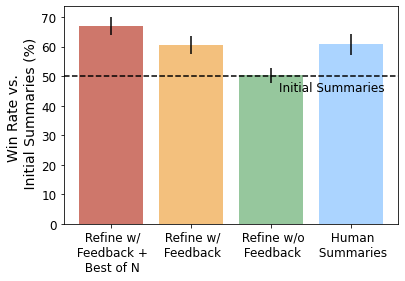

In [ ]:
params = {'font.size': 12, 'axes.labelsize': 14, 'legend.fontsize': 20, 'xtick.labelsize': 12, 'ytick.labelsize': 12}
matplotlib.rcParams.update(params)
plot_win_rate_against_original_summary(results_file, methods_without_original, evaluators, metric="win_rate_with_tie_scoring")

In [ ]:
result = pd.read_csv(results_file)
wins = result["feedback_refinements_reranking_comparison_rank_Jun"] < result["feedback_refinements_random_comparison_rank_Jun"]
ties = result["feedback_refinements_reranking_comparison_rank_Jun"] == result["feedback_refinements_random_comparison_rank_Jun"]
jun_score = wins + 0.5*ties
wins = result["feedback_refinements_reranking_comparison_rank_Angie"] < result["feedback_refinements_random_comparison_rank_Angie"]
ties = result["feedback_refinements_reranking_comparison_rank_Angie"] == result["feedback_refinements_random_comparison_rank_Angie"]
angie = wins + 0.5*ties


np.mean(jun_score.tolist()+angie.tolist())

0.58

## Win rate against human reference

In [ ]:
def add_linebreaks(text, max_line=12):
  words = text.split()
  new_text = ""
  current_line_len = 0
  for word in words:
    word = " " + word
    if current_line_len + len(word) > max_line:
      new_text += '\n' + word
      current_line_len = len(word)
    else:
      new_text += word
      current_line_len += len(word)
  return new_text

def plot_win_rate_against_human_summary(results_file: str, methods: List[str], evaluators: List[str], metric: str="win_rate_with_tie_scoring"): 
  #colors = ["#8ecbd7", "#abd4ff", "#96c79d", "#f3c07d", "#ce776b"]
  colors = ["#ce776b", "#f3c07d", "#96c79d", "#abd4ff"]
  result_dataframe = pd.read_csv(results_file)
  number_of_samples = result_dataframe.shape[0]

  win_rate_per_method = {}
  standard_error_of_win_rate_per_method = {}
  for method in methods:
    human_summaries_over_evaluators = []
    method_results_over_evaluators = []
    for evaluator in evaluators:
      human_summaries_over_evaluators += result_dataframe["human_reference_summaries_comparison_rank_{}".format(evaluator)].to_list()
      method_results_over_evaluators += result_dataframe[method + "_{}".format(evaluator)].to_list()
    
    assert len(human_summaries_over_evaluators) == len(method_results_over_evaluators) == number_of_samples*len(evaluators)
    human_summaries_over_evaluators = np.array(human_summaries_over_evaluators)
    method_results_over_evaluators = np.array(method_results_over_evaluators)
   
    if metric == "win_rate_with_tie_scoring": 
      wins = method_results_over_evaluators < human_summaries_over_evaluators
      ties =  method_results_over_evaluators == human_summaries_over_evaluators
      assert len(wins) == len(ties)

      current_method_performance = wins + 0.5*ties
    else: 
      raise NotImplementedError()    
    win_rate_per_method[method] = np.mean(current_method_performance)
    standard_error_of_win_rate_per_method[method] = sem(current_method_performance)
  
  method_titles = [add_linebreaks(method_names_for_plotting[method]) for method in methods]
  win_rates = [win_rate_per_method[method] * 100 for method in methods]
  standard_errors = [standard_error_of_win_rate_per_method[method] * 100 for method in methods]
  print(win_rate_per_method)
  print(standard_error_of_win_rate_per_method)
  print("Methods", method_titles)
  print("Win rates:", win_rates)
  print("Standard error",standard_errors )
  x_axis = range(len(methods))
  fig, ax = plt.subplots()
  ax.bar(x_axis, win_rates, yerr=standard_errors, color=colors)
  ax.axhline(y=50, color='black', linestyle='--')
  ax.text(2.1, 45, "Human Summaries")
  plt.ylabel("Win Rate vs. \n Human Summaries (%)")
  plt.xticks(x_axis, method_titles, rotation=0)
  plt.savefig(fig_output_path / f"win_rate_vs_human_summary_{metric}.pdf", bbox_inches='tight')
  plt.show()

{'feedback_refinements_reranking_comparison_rank': 0.54, 'feedback_refinements_random_comparison_rank': 0.52, 'general_refinements_random_comparison_rank': 0.4175, 'original_summary_comparison_rank': 0.3925}
{'feedback_refinements_reranking_comparison_rank': 0.035330457200978174, 'feedback_refinements_random_comparison_rank': 0.035059174671449644, 'general_refinements_random_comparison_rank': 0.034868291307339205, 'original_summary_comparison_rank': 0.03434189246226024}
Methods [' Refine w/\n Feedback +\n Best of N', ' Refine w/\n Feedback', ' Refine w/o\n Feedback', ' Initial\n Summaries']
Win rates: [54.0, 52.0, 41.75, 39.25]
Standard error [3.5330457200978174, 3.5059174671449647, 3.4868291307339208, 3.4341892462260244]


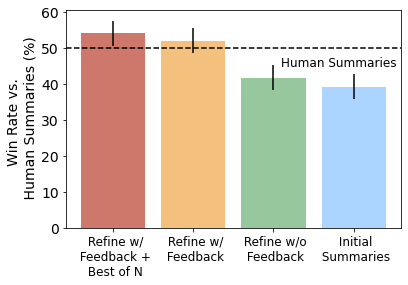

In [ ]:
params = {'font.size': 12, 'axes.labelsize': 14, 'legend.fontsize': 20, 'xtick.labelsize': 12, 'ytick.labelsize': 14}
matplotlib.rcParams.update(params)
models_without_human_ref = ["feedback_refinements_reranking_comparison_rank", "feedback_refinements_random_comparison_rank",
          "general_refinements_random_comparison_rank", "original_summary_comparison_rank"]
plot_win_rate_against_human_summary(results_file, models_without_human_ref, evaluators, metric="win_rate_with_tie_scoring")

## Performance vs original summary ranking

Remember for the below experiments that lower ranking is better.

In [ ]:
def plot_win_rate_against_original_summary_across_original_summary_performance(results_file: str, methods: List[str], evaluators: List[str], performance_metric="win_rate_with_tie_scores"): 
  colors = sns.color_palette("tab10", n_colors=4)
  result_dataframe = pd.read_csv(results_file)

  win_rate_per_orig_rating_per_method = {}
  standard_error_of_win_rate_per_orig_rating_per_method = {}
  for method in methods: 
    original_summaries_over_evaluators_ranking = []      
    method_results_over_evaluators_ranking = []

    for evaluator in evaluators:
      original_summaries_over_evaluators_ranking  += result_dataframe["original_summary_comparison_rank_{}".format(evaluator)].to_list()
      method_results_over_evaluators_ranking += result_dataframe[method + "_{}".format(evaluator)].to_list()


    assert len(original_summaries_over_evaluators_ranking) == len(method_results_over_evaluators_ranking) == result_dataframe.shape[0]*len(evaluators)

    original_summaries_over_evaluators_ranking_rounded = []
    method_results_over_evaluators_ranking_rounded = []
    for el in original_summaries_over_evaluators_ranking: 
        original_summaries_over_evaluators_ranking_rounded.append(round(el+ 1e-8))
    for el in method_results_over_evaluators_ranking: 
        method_results_over_evaluators_ranking_rounded.append(round(el+1e-8))
    assert len(original_summaries_over_evaluators_ranking_rounded) == len(method_results_over_evaluators_ranking_rounded)
    original_summaries_over_evaluators_ranking = np.array(original_summaries_over_evaluators_ranking_rounded)
    method_results_over_evaluators_ranking = np.array(method_results_over_evaluators_ranking_rounded)

    win_rate_per_rating = []
    standard_deviation_win_rate_per_rating = []
    for ranking in range(1,6): 
      current_ranking_indices = np.where(original_summaries_over_evaluators_ranking == ranking)
      current_original_summaries_rankings = original_summaries_over_evaluators_ranking[current_ranking_indices]
      current_method_ranking = method_results_over_evaluators_ranking[current_ranking_indices]
      
     
      if performance_metric == "win_rate_with_tie_scores": 
        wins = current_original_summaries_rankings > current_method_ranking
        ties =  current_original_summaries_rankings == current_method_ranking
        current_method_performance = wins + 0.5*ties

        assert len(wins) == len(ties)
      elif performance_metric == "ranking": 
        current_method_performance = current_method_ranking

      win_rate_per_rating.append(np.mean(current_method_performance))
      standard_deviation_win_rate_per_rating.append(sem(current_method_performance))

    win_rate_per_orig_rating_per_method[method] = np.array(win_rate_per_rating) * 100
    standard_error_of_win_rate_per_orig_rating_per_method[method] = np.array(standard_deviation_win_rate_per_rating) * 100
  
  print(win_rate_per_orig_rating_per_method)
  print(standard_error_of_win_rate_per_orig_rating_per_method)
  fig, ax = plt.subplots()
  for i, method in enumerate(methods): 
    if i == 0: 
      color = colors[3]
    elif i == 1: 
      color = colors[1]
    elif i == 2: 
      color = colors[2]
    elif i == 3: 
      color = colors[0]
    else: 
      raise NotImplementedError()

    plt.plot(range(1,6), win_rate_per_orig_rating_per_method[method], color=color, label=method_names_for_plotting[method],)
    ax.fill_between(range(1,6), 
                    win_rate_per_orig_rating_per_method[method]-standard_error_of_win_rate_per_orig_rating_per_method[method], 
                    win_rate_per_orig_rating_per_method[method]+standard_error_of_win_rate_per_orig_rating_per_method[method],
                    color=color, 
                    alpha=0.2)
  plt.xlabel("Ranking of Initial Summary")
  if performance_metric == "win_rate" or performance_metric == "win_rate_with_tie_scores": 
    plt.ylabel("Win Rate vs. \n Initial Summaries (%)")
    # plt.title("Win rate vs Initial Summary Ranking")
  elif performance_metric == "ranking": 
    plt.ylabel("Ranking")
    # plt.title("Ranking vs Initial Summary Ranking")
    ax.invert_yaxis()

  else: 
    raise NotImplementedError()
  # plt.legend()
  plt.xticks(range(1,6))
  plt.xlim(1, 5)
  plt.ylim(0, 100)
  # plt.legend(loc='upper center', bbox_to_anchor=(0.4, -0.2))
  plt.legend(loc='upper left', frameon=False)
  plt.savefig(fig_output_path / f"win_rate_against_original_summary_performance_{performance_metric}.pdf", bbox_inches='tight')
  plt.show()

{'feedback_refinements_reranking_comparison_rank': array([  0.        ,  15.625     ,  51.96078431,  88.        ,
       100.        ]), 'feedback_refinements_random_comparison_rank': array([ 0.        ,  7.8125    , 39.21568627, 83.        , 97.4137931 ]), 'general_refinements_random_comparison_rank': array([ 0.        , 31.25      , 40.19607843, 49.        , 77.5862069 ]), 'human_reference_summaries_comparison_rank': array([  0.        ,  25.        ,  48.03921569,  60.        ,
       100.        ])}
{'feedback_refinements_reranking_comparison_rank': array([0.        , 6.12269542, 6.09737718, 3.92792202, 0.        ]), 'feedback_refinements_random_comparison_rank': array([0.        , 3.95881965, 4.70996555, 3.94088978, 1.46671777]), 'general_refinements_random_comparison_rank': array([0.        , 5.83285328, 4.20541384, 5.4379618 , 3.29356505]), 'human_reference_summaries_comparison_rank': array([0.        , 7.77713771, 6.99590697, 6.85118789, 0.        ])}


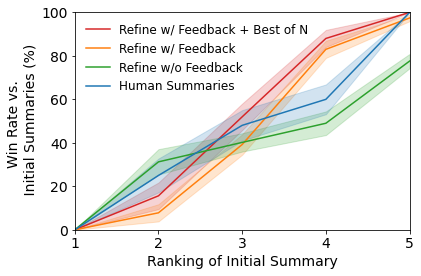

In [ ]:
params = {'font.size': 14, 'axes.labelsize': 14, 'legend.fontsize': 12, 'xtick.labelsize': 14, 'ytick.labelsize': 14}
matplotlib.rcParams.update(params)
plot_win_rate_against_original_summary_across_original_summary_performance(results_file, methods_without_original, evaluators, performance_metric="win_rate_with_tie_scores")


In [ ]:
#plot_win_rate_against_original_summary_across_original_summary_performance(results_file, methods_without_original, evaluators, performance_metric="win_rate")


In [ ]:
#plot_win_rate_against_original_summary_across_original_summary_performance(results_file, methods_without_original, evaluators, performance_metric="ranking")

# Feedback is incorporated Experiments

In [ ]:
methods = ["feedback_refinements_reranking", "feedback_refinements_random", "general_refinements_random"]
metrics = ["is_minimum_feedback_incorporated", "is_more_than_one_feedback_incorporated", "is_all_feedback_incorporated"]
methods_title = {"feedback_refinements_reranking": "Refine w/ Feedback + Best of N", 
                 "feedback_refinements_random": "Refine w/ Feedback", 
                 "general_refinements_random": "Refine w/o Feedback"}
metrics_title = {"is_minimum_feedback_incorporated": ">=1", 
                 "is_more_than_one_feedback_incorporated": ">1", 
                 "is_all_feedback_incorporated": "All"}
feedback_incorporated_results_file = "/content/drive/MyDrive/learning_from_natural_langauge_feedback/workshop_results/feedback_incorporated/human_eval_feedback_incorporated_summaries_with_aggregated_results.csv"


In [ ]:
def add_linebreaks(text, max_line=20):
  words = text.split()
  new_text = ""
  current_line_len = 0
  for word in words:
    word = " " + word
    if current_line_len + len(word) > max_line:
      new_text += '\n' + word
      current_line_len = len(word)
    else:
      new_text += word
      current_line_len += len(word)
  return new_text

def plot_feedback_incorporation(results_file: str, methods: List[str], metrics: List[str]): 
  colors = ["#ce776b", "#f3c07d", "#96c79d"]
  assert len(methods) == 3
  result_dataframe = pd.read_csv(results_file)
  mean_incorporation_per_metric = {}
  standard_error_of_incorporation_per_metric = {}
  for metric in metrics: 
    mean_incorporation_per_metric[metric] = {}
    standard_error_of_incorporation_per_metric[metric] = {}

  for metric in metrics:
    for method in methods: 
      metric_result = result_dataframe["{}_{}_{}".format(method, metric, "Jon")]
      mean_incorporation_per_metric[metric][method] = np.mean(metric_result)
      standard_error_of_incorporation_per_metric[metric][method] = sem(metric_result)

  
  x_axis = np.arange(3)
  width = 0.25

 
  fig, ax = plt.subplots()
  for i in range(3): 
    mean_results_across_metrics = []
    standard_error_results_across_metrics = []
    for metric in metrics:
      mean_results_across_metrics.append(mean_incorporation_per_metric[metric][methods[i]] * 100)
      standard_error_results_across_metrics.append(standard_error_of_incorporation_per_metric[metric][methods[i]] * 100)
    print(mean_incorporation_per_metric)
    print(standard_error_of_incorporation_per_metric)
    if i == 0:                                                                
      ax.bar(x_axis - width, mean_results_across_metrics, width, label=methods_title[methods[i]], yerr=standard_error_results_across_metrics, color = colors[i])
    elif i == 1: 
      ax.bar(x_axis , mean_results_across_metrics, width, label=methods_title[methods[i]],yerr=standard_error_results_across_metrics, color = colors[i])
    elif i == 2: 
      ax.bar(x_axis+ width , mean_results_across_metrics, width, label=methods_title[methods[i]],yerr=standard_error_results_across_metrics, color = colors[i])
    else: 
      raise NotImplementedError()

  metrics_titles = [add_linebreaks(metrics_title[metric]) for metric in metrics]
  plt.xticks(x_axis,metrics_titles , rotation=0)
  plt.xlabel("No. of feedback points incorporated")
  # plt.title("Is Feedback incorporated?")
  plt.ylabel("% of summaries \n incorporating feedback")
  plt.legend()
  plt.savefig(fig_output_path / f"feedback_incorporation.pdf", bbox_inches='tight')

{'is_minimum_feedback_incorporated': {'feedback_refinements_reranking': 0.72, 'feedback_refinements_random': 0.53, 'general_refinements_random': 0.15}, 'is_more_than_one_feedback_incorporated': {'feedback_refinements_reranking': 0.42, 'feedback_refinements_random': 0.23, 'general_refinements_random': 0.03}, 'is_all_feedback_incorporated': {'feedback_refinements_reranking': 0.25, 'feedback_refinements_random': 0.12, 'general_refinements_random': 0.0}}
{'is_minimum_feedback_incorporated': {'feedback_refinements_reranking': 0.045126085985421296, 'feedback_refinements_random': 0.05016135580465918, 'general_refinements_random': 0.03588702812826367}, 'is_more_than_one_feedback_incorporated': {'feedback_refinements_reranking': 0.04960449637488583, 'feedback_refinements_random': 0.04229525846816507, 'general_refinements_random': 0.01714466079977653}, 'is_all_feedback_incorporated': {'feedback_refinements_reranking': 0.04351941398892446, 'feedback_refinements_random': 0.032659863237109045, 'gen

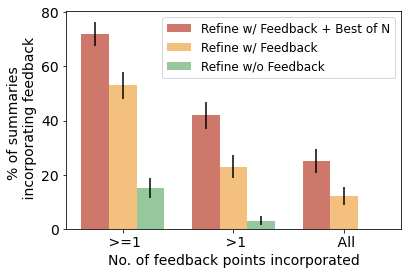

In [ ]:
params = {'font.size': 14, 'axes.labelsize': 14, 'legend.fontsize': 12, 'xtick.labelsize': 14, 'ytick.labelsize': 14}
matplotlib.rcParams.update(params)
plot_feedback_incorporation(feedback_incorporated_results_file, methods=methods, metrics=metrics)

In [ ]:
def plot_feedback_incorporation_per_original_summary_rating(is_feedback_incorporated_results_file: str, 
                                                            summary_ranking_results_file: str, 
                                                            methods: List[str], metrics: List[str], evaluators: List[str]): 
  colors = sns.color_palette("tab10", n_colors=4)
  feedback_incorporated_results = pd.read_csv(is_feedback_incorporated_results_file)
  summary_comparison_results = pd.read_csv(summary_ranking_results_file)

  evaluator_ranking_ids = {}
  for i, evaluator in enumerate(evaluators):
    original_summarie_rankings = summary_comparison_results["original_summary_comparison_rank_{}".format(evaluator)].to_numpy()

    all_ranking_ids = []
    for ranking in range(1,6): 
      current_ranking_indices = np.where(original_summarie_rankings == ranking)
      all_ranking_ids.append(summary_comparison_results.iloc[current_ranking_indices]["id"].tolist())
    evaluator_ranking_ids[evaluator] = all_ranking_ids
  
  for metric in metrics: 
    fig, ax = plt.subplots()
    for i, method in enumerate(methods): 
      x_axis = range(1,6)
      results_mean = []
      results_standard_error = []
      for ranking in range(5):
        is_incorporated_across_evaluators = []
        for evaluator in evaluators:
          selected_results = feedback_incorporated_results[feedback_incorporated_results["id"].isin(evaluator_ranking_ids[evaluator][ranking])]
          is_incorporated = selected_results["{}_{}_{}".format(method, metric, "Jon")].tolist()
          is_incorporated_across_evaluators += is_incorporated
        results_mean.append(np.mean(is_incorporated_across_evaluators))
        results_standard_error.append(sem(is_incorporated_across_evaluators))
      results_mean = np.array(results_mean)
      results_standard_error = np.array(results_standard_error)

      if i == 0: 
        color = colors[3]
      elif i == 1: 
        color = colors[1]
      elif i == 2: 
        color = colors[2]
      elif i == 3: 
        color = colors[0]
      else: 
        raise NotImplementedError()
      ax.plot(x_axis, results_mean, color=color, label=methods_title[method])
      ax.fill_between(x_axis, 
                    results_mean-results_standard_error, 
                    results_mean+results_standard_error,
                    color=color, 
                    alpha=0.2)
      plt.xlabel("Ranking of initial summaries")
      plt.ylabel(metrics_title[metric])
      plt.legend(loc='upper center', bbox_to_anchor=(1.5, 0.8))
    plt.savefig(fig_output_path / f"feedback_incorporation_per_original_summary_rating_{metric}.pdf", bbox_inches='tight')
        

In [ ]:
#plot_feedback_incorporation_per_original_summary_rating(feedback_incorporated_results_file, 
#                                                        results_file, 
#                                                        methods, metrics, evaluators)

# Finetuning Human Comparisons

In [ ]:
results_file = "/content/drive/MyDrive/learning_from_natural_langauge_feedback/workshop_results/finetuning/human_eval_finetuning_summaries_with_aggregated_results.csv"
methods_without_human = ["davinci_summary_comparison_rank", "finetuned_feedback_refinement_summary_comparison_rank",
           "finetuned_original_summary_comparison_rank", "davinci_instruct_comparison_rank"
           ]
methods_without_human =["finetuned_feedback_refinement_summary_comparison_rank", "finetuned_original_summary_comparison_rank", "davinci_instruct_comparison_rank", "davinci_summary_comparison_rank"]
methods_without_instruct =["finetuned_feedback_refinement_summary_comparison_rank", "finetuned_original_summary_comparison_rank", "davinci_summary_comparison_rank", "human_reference_summaries_comparison_rank"]

all_methods =["finetuned_feedback_refinement_summary_comparison_rank", "finetuned_original_summary_comparison_rank", "davinci_instruct_comparison_rank", "davinci_summary_comparison_rank", "human_reference_summaries_comparison_rank"]
           
method_names_for_plotting = {"davinci_summary_comparison_rank": "GPT-3", 
                             "davinci_instruct_comparison_rank": "InstructGPT",
                             "finetuned_feedback_refinement_summary_comparison_rank": "GPT-3 Finetuned on Refine w/ Feedback + Best of N", 
                             "finetuned_original_summary_comparison_rank": "GPT-3 Finetuned on Initial Summaries", 
                             "human_reference_summaries_comparison_rank": "Human Summaries"
                             }
evaluators = ["Jun"]

In [ ]:
def calcualte_average_ranking_per_finetuning_summary(results_file: str, methods: List[str], evaluators: List[str]): 
  result_dataframe = pd.read_csv(results_file)
  mean_rank_per_method = {}
  standard_error_of_rank_per_method = {}
  for method in methods: 
    results = []
    for evaluator in evaluators: 
      results += result_dataframe[method + "_{}".format(evaluator)].to_list()
    results = np.array(results)
    mean_rank_per_method[method] = np.mean(results)
    standard_error_of_rank_per_method[method] = sem(results)

  for method in methods: 
    print("Average Ranking:")
    print("{}: {} +/- {}".format(method_names_for_plotting[method],mean_rank_per_method[method], standard_error_of_rank_per_method[method]))

In [ ]:
calcualte_average_ranking_per_finetuning_summary(results_file, all_methods, evaluators)

Average Ranking:
GPT-3 Finetuned on Refine w/ Feedback + Best of N: 2.55 +/- 0.13880805728658824
Average Ranking:
GPT-3 Finetuned on Initial Summaries: 2.78 +/- 0.12758835322547227
Average Ranking:
InstructGPT: 3.15 +/- 0.13437096247164249
Average Ranking:
GPT-3: 4.03 +/- 0.11586739198433926
Average Ranking:
Human Summaries: 2.49 +/- 0.13370780746754388


### Direct comparison Our method vs finetuning on original

In [ ]:
res = pd.read_csv(results_file)
feedback_finetuning = res["finetuned_feedback_refinement_summary_comparison_rank_Jun"]
original_finetuning = res["finetuned_original_summary_comparison_rank_Jun"]
#human_ref = res["human_reference_summaries_comparison_rank_Jun"]
wins = feedback_finetuning < original_finetuning
ties = feedback_finetuning == original_finetuning
performance = wins + 0.5*ties
win_rate = np.mean(performance)
standard_error = sem(performance)
print("Win rate {} +/- {}".format(100*win_rate, 100*standard_error))


#wins = feedback_finetuning < human_ref
#ties = feedback_finetuning == human_ref
#print("win rate feed vs ref {}".format(np.mean(wins + 0.5*ties)))

#wins = original_finetuning < human_ref
#ties = original_finetuning == human_ref
#print("win rate orig vs ref {}".format(np.mean(wins + 0.5*ties)))

Win rate 56.99999999999999 +/- 4.97569851956243


In [ ]:
def add_linebreaks(text, max_line=12):
  words = text.split()
  new_text = ""
  current_line_len = 0
  for word in words:
    word = " " + word
    if current_line_len + len(word) > max_line:
      new_text += '\n' + word
      current_line_len = len(word)
    else:
      new_text += word
      current_line_len += len(word)
  return new_text

def plot_finetuning_win_rate_against_human_summary(results_file: str, methods: List[str], evaluators: List[str], metric: str="win_rate_with_tie_scoring"): 
  #colors = ["#8ecbd7", "#abd4ff", "#96c79d", "#f3c07d", "#ce776b"]
  colors = ["#ce776b", "#f3c07d", "#96c79d", "#abd4ff"]
  result_dataframe = pd.read_csv(results_file)
  number_of_samples = result_dataframe.shape[0]

  win_rate_per_method = {}
  standard_error_of_win_rate_per_method = {}
  for method in methods:
    compraison_summaries_over_evaluators = []
    method_results_over_evaluators = []
    for evaluator in evaluators:
      compraison_summaries_over_evaluators += result_dataframe["human_reference_summaries_comparison_rank_{}".format(evaluator)].to_list()
      method_results_over_evaluators += result_dataframe[method + "_{}".format(evaluator)].to_list()
    
    assert len(compraison_summaries_over_evaluators) == len(method_results_over_evaluators) == number_of_samples*len(evaluators)
    compraison_summaries_over_evaluators = np.array(compraison_summaries_over_evaluators)
    method_results_over_evaluators = np.array(method_results_over_evaluators)
   
    if metric == "win_rate_with_tie_scoring": 
      wins = method_results_over_evaluators < compraison_summaries_over_evaluators
      ties =  method_results_over_evaluators == compraison_summaries_over_evaluators
      assert len(wins) == len(ties)
      current_method_performance = wins + 0.5*ties
    else: 
      raise NotImplementedError()    
    win_rate_per_method[method] = np.mean(current_method_performance)
    standard_error_of_win_rate_per_method[method] = sem(current_method_performance)
  
  print(win_rate_per_method)
  print(standard_error_of_win_rate_per_method)
  method_titles = [add_linebreaks(method_names_for_plotting[method]) for method in methods]
  win_rates = [win_rate_per_method[method] * 100 for method in methods]
  standard_errors = [standard_error_of_win_rate_per_method[method] * 100 for method in methods]
  x_axis = range(len(methods))
  fig, ax = plt.subplots()
  ax.bar(x_axis, win_rates, yerr=standard_errors, color=colors)
  ax.axhline(y=50, color='black', linestyle='--')
  ax.text(2.1, 45, "Human Summaries")
  plt.ylabel("Win Rate vs. \n Human Summaries (%)")
  plt.xticks(x_axis, method_titles, rotation=0)
  plt.savefig(fig_output_path / f"finetuning_win_rate_vs_human_summary_{metric}.pdf", bbox_inches='tight')
  plt.show()

In [ ]:
def plot_finetuning_win_rate_against_instruct_summary(results_file: str, methods: List[str], evaluators: List[str], metric: str="win_rate_with_tie_scoring"): 
  #colors = ["#8ecbd7", "#abd4ff", "#96c79d", "#f3c07d", "#ce776b"]
  colors = ["#ce776b", "#f3c07d", "#96c79d", "#abd4ff"]
  result_dataframe = pd.read_csv(results_file)
  number_of_samples = result_dataframe.shape[0]

  win_rate_per_method = {}
  standard_error_of_win_rate_per_method = {}
  for method in methods:
    compraison_summaries_over_evaluators = []
    method_results_over_evaluators = []
    for evaluator in evaluators:
      compraison_summaries_over_evaluators += result_dataframe["davinci_instruct_comparison_rank_{}".format(evaluator)].to_list()
      method_results_over_evaluators += result_dataframe[method + "_{}".format(evaluator)].to_list()
    
    assert len(compraison_summaries_over_evaluators) == len(method_results_over_evaluators) == number_of_samples*len(evaluators)
    compraison_summaries_over_evaluators = np.array(compraison_summaries_over_evaluators)
    method_results_over_evaluators = np.array(method_results_over_evaluators)
   
    if metric == "win_rate_with_tie_scoring": 
      wins = method_results_over_evaluators < compraison_summaries_over_evaluators
      ties =  method_results_over_evaluators == compraison_summaries_over_evaluators
      assert len(wins) == len(ties)

      current_method_performance = wins + 0.5*ties
    else: 
      raise NotImplementedError()    
    win_rate_per_method[method] = np.mean(current_method_performance)
    standard_error_of_win_rate_per_method[method] = sem(current_method_performance)
  
  print(win_rate_per_method)
  print(standard_error_of_win_rate_per_method)
  method_titles = [add_linebreaks(method_names_for_plotting[method]) for method in methods]
  win_rates = [win_rate_per_method[method] * 100 for method in methods]
  standard_errors = [standard_error_of_win_rate_per_method[method] * 100 for method in methods]
  x_axis = range(len(methods))
  fig, ax = plt.subplots()
  ax.bar(x_axis, win_rates, yerr=standard_errors, color=colors)
  ax.axhline(y=50, color='black', linestyle='--')
  ax.text(1.7, 45, "InstructGPT Summaries")
  plt.ylabel("Win Rate vs. \n Initial Summaries (%)")
  plt.xticks(x_axis, method_titles, rotation=0)
  plt.savefig(fig_output_path / f"finetuning_win_rate_vs_original_summary_{metric}.pdf", bbox_inches='tight')
  plt.show()

In [ ]:
def plot_win_rate_against_human_summary_across_human_summary_performance(results_file: str, methods: List[str], evaluators: List[str], performance_metric="win_rate_with_tie_scores"): 
  colors = sns.color_palette("tab10", n_colors=4)
  result_dataframe = pd.read_csv(results_file)

  win_rate_per_orig_rating_per_method = {}
  standard_error_of_win_rate_per_orig_rating_per_method = {}
  for method in methods: 
    human_summaries_over_evaluators_ranking = []      
    method_results_over_evaluators_ranking = []

    for evaluator in evaluators:
      human_summaries_over_evaluators_ranking  += result_dataframe["human_reference_summaries_comparison_rank_{}".format(evaluator)].to_list()
      method_results_over_evaluators_ranking += result_dataframe[method + "_{}".format(evaluator)].to_list()


    assert len(human_summaries_over_evaluators_ranking) == len(method_results_over_evaluators_ranking) == result_dataframe.shape[0]*len(evaluators)
    human_summaries_over_evaluators_ranking = np.array(human_summaries_over_evaluators_ranking)
    method_results_over_evaluators_ranking = np.array(method_results_over_evaluators_ranking)

    win_rate_per_rating = []
    standard_deviation_win_rate_per_rating = []
    for ranking in range(1,6): 
      current_ranking_indices = np.where(human_summaries_over_evaluators_ranking == ranking)
      current_human_summaries_rankings = human_summaries_over_evaluators_ranking[current_ranking_indices]
      current_method_ranking = method_results_over_evaluators_ranking[current_ranking_indices]
      
     
      if performance_metric == "win_rate_with_tie_scores": 
        wins = current_human_summaries_rankings > current_method_ranking
        ties =  current_human_summaries_rankings == current_method_ranking
        current_method_performance = wins + 0.5*ties

        assert len(wins) == len(ties)
      elif performance_metric == "ranking": 
        current_method_performance = current_method_ranking

      win_rate_per_rating.append(np.mean(current_method_performance))
      standard_deviation_win_rate_per_rating.append(sem(current_method_performance))

    win_rate_per_orig_rating_per_method[method] = np.array(win_rate_per_rating) * 100
    standard_error_of_win_rate_per_orig_rating_per_method[method] = np.array(standard_deviation_win_rate_per_rating) * 100
  
  print(win_rate_per_orig_rating_per_method)
  fig, ax = plt.subplots()
  for i, method in enumerate(methods): 
    if i == 0: 
      color = colors[3]
    elif i == 1: 
      color = colors[1]
    elif i == 2: 
      color = colors[2]
    elif i == 3: 
      color = colors[0]
    else: 
      raise NotImplementedError()

    method_name_for_plotting = method_names_for_plotting[method]
    if "GPT-3 Finetuned" in method_name_for_plotting:
      method_name_for_plotting = "on\n".join(method_name_for_plotting.split("on "))
    plt.plot(range(1,6), win_rate_per_orig_rating_per_method[method], color=color, label=method_name_for_plotting,)
    ax.fill_between(range(1,6), 
                    win_rate_per_orig_rating_per_method[method]-standard_error_of_win_rate_per_orig_rating_per_method[method], 
                    win_rate_per_orig_rating_per_method[method]+standard_error_of_win_rate_per_orig_rating_per_method[method],
                    color=color, 
                    alpha=0.2)
  plt.xlabel("Ranking of Human Summary")
  if performance_metric == "win_rate" or performance_metric == "win_rate_with_tie_scores": 
    plt.ylabel("Win Rate vs. \n Human Summary (%)")
    # plt.title("Win rate vs Initial Summary Ranking")
  elif performance_metric == "ranking": 
    plt.ylabel("Ranking")
    # plt.title("Ranking vs Initial Summary Ranking")
    ax.invert_yaxis()

  else: 
    raise NotImplementedError()
  # plt.legend()
  plt.xticks(range(1,6))
  plt.xlim(1, 5)
  plt.ylim(0, 100)
  # plt.legend(loc='upper center', bbox_to_anchor=(0.4, -0.2))
  plt.legend(loc='upper left', frameon=False)
  plt.savefig(fig_output_path / f"finetuning_win_rate_against_human_summary_performance_{performance_metric}.pdf", bbox_inches='tight')
  plt.show()

In [ ]:
def plot_win_rate_against_instruct_summary_across_instruct_summary_performance(results_file: str, methods: List[str], evaluators: List[str], performance_metric="win_rate_with_tie_scores"): 
  colors = sns.color_palette("tab10", n_colors=4)
  result_dataframe = pd.read_csv(results_file)

  win_rate_per_orig_rating_per_method = {}
  standard_error_of_win_rate_per_orig_rating_per_method = {}
  for method in methods: 
    original_summaries_over_evaluators_ranking = []      
    method_results_over_evaluators_ranking = []

    for evaluator in evaluators:
      original_summaries_over_evaluators_ranking  += result_dataframe["davinci_instruct_comparison_rank_{}".format(evaluator)].to_list()
      method_results_over_evaluators_ranking += result_dataframe[method + "_{}".format(evaluator)].to_list()


    assert len(original_summaries_over_evaluators_ranking) == len(method_results_over_evaluators_ranking) == result_dataframe.shape[0]*len(evaluators)
    original_summaries_over_evaluators_ranking = np.array(original_summaries_over_evaluators_ranking)
    method_results_over_evaluators_ranking = np.array(method_results_over_evaluators_ranking)

    win_rate_per_rating = []
    standard_deviation_win_rate_per_rating = []
    for ranking in range(1,6): 
      current_ranking_indices = np.where(original_summaries_over_evaluators_ranking == ranking)
      current_original_summaries_rankings = original_summaries_over_evaluators_ranking[current_ranking_indices]
      current_method_ranking = method_results_over_evaluators_ranking[current_ranking_indices]
      
     
      if performance_metric == "win_rate_with_tie_scores": 
        wins = current_original_summaries_rankings > current_method_ranking
        ties =  current_original_summaries_rankings == current_method_ranking
        current_method_performance = wins + 0.5*ties

        assert len(wins) == len(ties)
      elif performance_metric == "ranking": 
        current_method_performance = current_method_ranking

      win_rate_per_rating.append(np.mean(current_method_performance))
      standard_deviation_win_rate_per_rating.append(sem(current_method_performance))

    win_rate_per_orig_rating_per_method[method] = np.array(win_rate_per_rating) * 100
    standard_error_of_win_rate_per_orig_rating_per_method[method] = np.array(standard_deviation_win_rate_per_rating) * 100
  
  print(win_rate_per_orig_rating_per_method)
  fig, ax = plt.subplots()
  for i, method in enumerate(methods): 
    if i == 0: 
      color = colors[3]
    elif i == 1: 
      color = colors[1]
    elif i == 2: 
      color = colors[2]
    elif i == 3: 
      color = colors[0]
    else: 
      raise NotImplementedError()

    method_name_for_plotting = method_names_for_plotting[method]
    if "GPT-3 Finetuned" in method_name_for_plotting:
      method_name_for_plotting = "on\n".join(method_name_for_plotting.split("on "))
    plt.plot(range(1,6), win_rate_per_orig_rating_per_method[method], color=color, label=method_name_for_plotting,)
    ax.fill_between(range(1,6), 
                    win_rate_per_orig_rating_per_method[method]-standard_error_of_win_rate_per_orig_rating_per_method[method], 
                    win_rate_per_orig_rating_per_method[method]+standard_error_of_win_rate_per_orig_rating_per_method[method],
                    color=color, 
                    alpha=0.2)
  plt.xlabel("Ranking of Initial Summary")
  if performance_metric == "win_rate" or performance_metric == "win_rate_with_tie_scores": 
    plt.ylabel("Win Rate vs. \n Initial Summary (%)")
    # plt.title("Win rate vs Initial Summary Ranking")
  elif performance_metric == "ranking": 
    plt.ylabel("Ranking")
    # plt.title("Ranking vs Initial Summary Ranking")
    ax.invert_yaxis()

  else: 
    raise NotImplementedError()
  # plt.legend()
  plt.xticks(range(1,6))
  plt.xlim(1, 5)
  plt.ylim(0, 100)
  # plt.legend(loc='upper center', bbox_to_anchor=(0.4, -0.2))
  plt.legend(loc='upper left', frameon=False)
  plt.savefig(fig_output_path / f"finetuning_win_rate_against_original_summary_performance_{performance_metric}.pdf", bbox_inches='tight')
  plt.show()

{'finetuned_feedback_refinement_summary_comparison_rank': 0.62, 'finetuned_original_summary_comparison_rank': 0.59, 'davinci_summary_comparison_rank': 0.29, 'human_reference_summaries_comparison_rank': 0.65}
{'finetuned_feedback_refinement_summary_comparison_rank': 0.048783173121456344, 'finetuned_original_summary_comparison_rank': 0.04943110704237103, 'davinci_summary_comparison_rank': 0.045604802157206865, 'human_reference_summaries_comparison_rank': 0.047937248544110224}


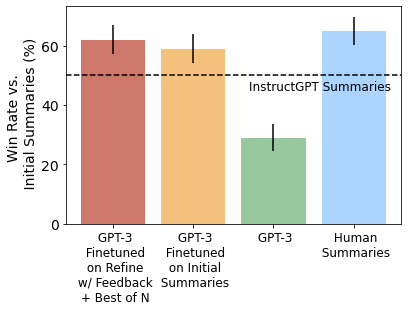

In [ ]:
params = {'font.size': 12, 'axes.labelsize': 14, 'legend.fontsize': 20, 'xtick.labelsize': 12, 'ytick.labelsize': 14}
matplotlib.rcParams.update(params)
plot_finetuning_win_rate_against_instruct_summary(results_file, methods_without_instruct, evaluators, metric="win_rate_with_tie_scoring")

{'finetuned_feedback_refinement_summary_comparison_rank': 0.51, 'finetuned_original_summary_comparison_rank': 0.44, 'davinci_instruct_comparison_rank': 0.35, 'davinci_summary_comparison_rank': 0.19}
{'finetuned_feedback_refinement_summary_comparison_rank': 0.05024183937956913, 'finetuned_original_summary_comparison_rank': 0.04988876515698589, 'davinci_instruct_comparison_rank': 0.047937248544110224, 'davinci_summary_comparison_rank': 0.039427724440366255}


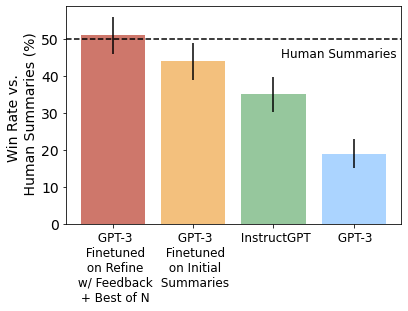

In [ ]:
params = {'font.size': 12, 'axes.labelsize': 14, 'legend.fontsize': 20, 'xtick.labelsize': 12, 'ytick.labelsize': 14}
matplotlib.rcParams.update(params)
plot_finetuning_win_rate_against_human_summary(results_file, methods_without_human, evaluators, metric="win_rate_with_tie_scoring")

In [ ]:
params = {'font.size': 14, 'axes.labelsize': 14, 'legend.fontsize': 12, 'xtick.labelsize': 14, 'ytick.labelsize': 14}
matplotlib.rcParams.update(params)
#plot_win_rate_against_instruct_summary_across_instruct_summary_performance(results_file, methods_without_instruct, evaluators, performance_metric="win_rate_with_tie_scores")

In [ ]:
params = {'font.size': 14, 'axes.labelsize': 14, 'legend.fontsize': 12, 'xtick.labelsize': 14, 'ytick.labelsize': 14}
matplotlib.rcParams.update(params)
#plot_win_rate_against_human_summary_across_human_summary_performance(results_file, methods_without_human, evaluators, performance_metric="win_rate_with_tie_scores")